## Data Gathering & Extraction (Most Popular Movie in Romance Genre)

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Base URL for the AJAX requests to load more reviews
base_url = "https://www.imdb.com/title/tt8740790/reviews/_ajax"

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

# Initialize empty lists to store data from web scraping
review_titles = []
review_contents = []
ratings = []

# Function to extract reviews from the current page
def extract_reviews(soup):
    review_data = soup.find_all('div', {"class": "review-container"})
    for row in review_data:
        # Extract review title data
        review_title_element = row.find("a", {"class": "title"})
        if review_title_element:
            review_titles.append(review_title_element.text.strip())

        # Extract review content data
        review_content_element = row.find("div", {"class": "text show-more__control"})
        if review_content_element:
            review_contents.append(review_content_element.text.strip())
            
        # Extract rating score (assuming the structure is consistent)
        rating_element = row.find("span", class_="rating-other-user-rating")  # Target the relevant element
        if rating_element:
            score_element = rating_element.find("span", string=lambda text: text and text.isdigit())
            if score_element:
                ratings.append(score_element.text.strip())
            else:
                ratings.append(None)  # Append None if rating not found within the element
        else:
            ratings.append(None)  # Append None if the entire rating element is not found

# Initial request to get the first page
response = requests.get(base_url, headers=headers, timeout=10)
soup = BeautifulSoup(response.text, "html.parser")
extract_reviews(soup)

# Find the pagination key for the next page
load_more_data = soup.find("div", {"class": "load-more-data"})
pagination_key = load_more_data["data-key"] if load_more_data else None

# Loop through subsequent pages until there are no more pages
while pagination_key:
    try:
        response = requests.get(base_url, headers=headers, params={"paginationKey": pagination_key}, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")
        extract_reviews(soup)
        load_more_data = soup.find("div", {"class": "load-more-data"})
        pagination_key = load_more_data["data-key"] if load_more_data else None
        time.sleep(3)  # Adding a delay to avoid overwhelming the server
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        time.sleep(5)  # Wait before retrying
        continue

# Create the DataFrame
df = pd.DataFrame({'Title': review_titles, 'Review': review_contents, 'Rating Score': ratings,})

# Specify the filename
file_name = 'romance_imdb_reviews.csv'

# Save the DataFrame to a CSV file
df.to_csv(file_name, index=False)  # Avoid including the index column

print("DataFrame saved to", file_name)


DataFrame saved to romance_imdb_reviews.csv


# 1. Data Cleaning (Text Preprocessing)

In [2]:
import pandas as pd

#read CSV into DataFrame
df = pd.read_csv("romance_imdb_reviews.csv")
df

,Title,Review,Rating Score
0,"A fun, dramatic, fantasty gulity pleasure.","As a 23 year old black dude, I actually liked ...",7.0
1,Breathtakingly Beige,If you're going to be historically inaccurate ...,7.0
2,It is entertainment,This is not a quality Jennifer Ehle/Colin Firt...,7.0
3,Mainstream Wattpad Historical Romance,Let me just start that I am a fan of the books...,8.0
4,Not as bad as many reviews say,I read a lot of negative reviews. Especially a...,8.0
...,...,...,...
1910,season 1 was horrendous but season 2 was enjoy...,"S1 was gross to put it best, the main characte...",4.0
1911,maybe im just not good with romances lol,Ok so i thought it wasnt too bad up until arou...,5.0
1912,Target audience acquired,This show is for the enjoyment of married wome...,5.0
1913,I gave it another try and I liked it better bu...,I wrote a review 2 weeks ago which has now dis...,5.0


### Basic Text Preprocessing

In [3]:
df = df[['Title', 'Review', 'Rating Score']]
display(df)

,Title,Review,Rating Score
0,"A fun, dramatic, fantasty gulity pleasure.","As a 23 year old black dude, I actually liked ...",7.0
1,Breathtakingly Beige,If you're going to be historically inaccurate ...,7.0
2,It is entertainment,This is not a quality Jennifer Ehle/Colin Firt...,7.0
3,Mainstream Wattpad Historical Romance,Let me just start that I am a fan of the books...,8.0
4,Not as bad as many reviews say,I read a lot of negative reviews. Especially a...,8.0
...,...,...,...
1910,season 1 was horrendous but season 2 was enjoy...,"S1 was gross to put it best, the main characte...",4.0
1911,maybe im just not good with romances lol,Ok so i thought it wasnt too bad up until arou...,5.0
1912,Target audience acquired,This show is for the enjoyment of married wome...,5.0
1913,I gave it another try and I liked it better bu...,I wrote a review 2 weeks ago which has now dis...,5.0


### Remove Punctuation

In [4]:
#import string module for string manipulation
import string

#The constant in string module to remove punctuations
string.punctuation

#defining the function to remove punctuations in the documents
def remove_punctuation(Text):
    #punctuationfree = "".join([i for i in text if i not in string.punctuation])
    #return punctuationfree
    # Initialize an empty string to store the result
    punctuation_free = ""
    
    # Iterate over each character in the text
    for i in Text:
        # Check if the character is not in the string.punctuation set
        if i not in string.punctuation:
            # If not, add the character to the result string
            punctuation_free += i
    
    return punctuation_free

In [5]:
# Convert non-string values to strings in 'Text' column
df['Review'] = df['Review'].astype(str)

# Apply remove_punctuation function to 'Text' column and store result in 'clean_text' column
df['clean_punc_review'] = df['Review'].apply(remove_punctuation)

# Display the resulting DataFrame
df

,Title,Review,Rating Score,clean_punc_review
0,"A fun, dramatic, fantasty gulity pleasure.","As a 23 year old black dude, I actually liked ...",7.0,As a 23 year old black dude I actually liked t...
1,Breathtakingly Beige,If you're going to be historically inaccurate ...,7.0,If youre going to be historically inaccurate i...
2,It is entertainment,This is not a quality Jennifer Ehle/Colin Firt...,7.0,This is not a quality Jennifer EhleColin Firth...
3,Mainstream Wattpad Historical Romance,Let me just start that I am a fan of the books...,8.0,Let me just start that I am a fan of the books...
4,Not as bad as many reviews say,I read a lot of negative reviews. Especially a...,8.0,I read a lot of negative reviews Especially ab...
...,...,...,...,...
1910,season 1 was horrendous but season 2 was enjoy...,"S1 was gross to put it best, the main characte...",4.0,S1 was gross to put it best the main character...
1911,maybe im just not good with romances lol,Ok so i thought it wasnt too bad up until arou...,5.0,Ok so i thought it wasnt too bad up until arou...
1912,Target audience acquired,This show is for the enjoyment of married wome...,5.0,This show is for the enjoyment of married wome...
1913,I gave it another try and I liked it better bu...,I wrote a review 2 weeks ago which has now dis...,5.0,I wrote a review 2 weeks ago which has now dis...


### Convert Text into Lowercase

In [6]:
#to standardize the cases in the documents into lower case
df['clean_lower']= df['clean_punc_review'].str.lower()
df

,Title,Review,Rating Score,clean_punc_review,clean_lower
0,"A fun, dramatic, fantasty gulity pleasure.","As a 23 year old black dude, I actually liked ...",7.0,As a 23 year old black dude I actually liked t...,as a 23 year old black dude i actually liked t...
1,Breathtakingly Beige,If you're going to be historically inaccurate ...,7.0,If youre going to be historically inaccurate i...,if youre going to be historically inaccurate i...
2,It is entertainment,This is not a quality Jennifer Ehle/Colin Firt...,7.0,This is not a quality Jennifer EhleColin Firth...,this is not a quality jennifer ehlecolin firth...
3,Mainstream Wattpad Historical Romance,Let me just start that I am a fan of the books...,8.0,Let me just start that I am a fan of the books...,let me just start that i am a fan of the books...
4,Not as bad as many reviews say,I read a lot of negative reviews. Especially a...,8.0,I read a lot of negative reviews Especially ab...,i read a lot of negative reviews especially ab...
...,...,...,...,...,...
1910,season 1 was horrendous but season 2 was enjoy...,"S1 was gross to put it best, the main characte...",4.0,S1 was gross to put it best the main character...,s1 was gross to put it best the main character...
1911,maybe im just not good with romances lol,Ok so i thought it wasnt too bad up until arou...,5.0,Ok so i thought it wasnt too bad up until arou...,ok so i thought it wasnt too bad up until arou...
1912,Target audience acquired,This show is for the enjoyment of married wome...,5.0,This show is for the enjoyment of married wome...,this show is for the enjoyment of married wome...
1913,I gave it another try and I liked it better bu...,I wrote a review 2 weeks ago which has now dis...,5.0,I wrote a review 2 weeks ago which has now dis...,i wrote a review 2 weeks ago which has now dis...


### Remove Digits and Hypens

In [7]:
#import regular expression library
import re

#function to remove digit (\d) or hypens (-) from the documents with an empty string ''
def remove_numbers(Text):
    return re.sub("[\d-]",'',Text)

#applying the remove_numbers function to the 'clean_lower' column and storing the result in a new column 'clean_number'
df['clean_number'] = df['clean_lower'].apply(remove_numbers)
df

,Title,Review,Rating Score,clean_punc_review,clean_lower,clean_number
0,"A fun, dramatic, fantasty gulity pleasure.","As a 23 year old black dude, I actually liked ...",7.0,As a 23 year old black dude I actually liked t...,as a 23 year old black dude i actually liked t...,as a year old black dude i actually liked thi...
1,Breathtakingly Beige,If you're going to be historically inaccurate ...,7.0,If youre going to be historically inaccurate i...,if youre going to be historically inaccurate i...,if youre going to be historically inaccurate i...
2,It is entertainment,This is not a quality Jennifer Ehle/Colin Firt...,7.0,This is not a quality Jennifer EhleColin Firth...,this is not a quality jennifer ehlecolin firth...,this is not a quality jennifer ehlecolin firth...
3,Mainstream Wattpad Historical Romance,Let me just start that I am a fan of the books...,8.0,Let me just start that I am a fan of the books...,let me just start that i am a fan of the books...,let me just start that i am a fan of the books...
4,Not as bad as many reviews say,I read a lot of negative reviews. Especially a...,8.0,I read a lot of negative reviews Especially ab...,i read a lot of negative reviews especially ab...,i read a lot of negative reviews especially ab...
...,...,...,...,...,...,...
1910,season 1 was horrendous but season 2 was enjoy...,"S1 was gross to put it best, the main characte...",4.0,S1 was gross to put it best the main character...,s1 was gross to put it best the main character...,s was gross to put it best the main character ...
1911,maybe im just not good with romances lol,Ok so i thought it wasnt too bad up until arou...,5.0,Ok so i thought it wasnt too bad up until arou...,ok so i thought it wasnt too bad up until arou...,ok so i thought it wasnt too bad up until arou...
1912,Target audience acquired,This show is for the enjoyment of married wome...,5.0,This show is for the enjoyment of married wome...,this show is for the enjoyment of married wome...,this show is for the enjoyment of married wome...
1913,I gave it another try and I liked it better bu...,I wrote a review 2 weeks ago which has now dis...,5.0,I wrote a review 2 weeks ago which has now dis...,i wrote a review 2 weeks ago which has now dis...,i wrote a review weeks ago which has now disa...


### Remove Unwanted Characters

In [8]:
# Function to remove unwanted characters
def remove_unwanted_chars(text):
    # Define your set of unwanted characters here
    unwanted_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '"', '(', ')', '_', '+', '=', '[', ']', '{', '}', ';', ':', '<', '>', ',', '.', '/', '?', '\\', '|']
    # Replace unwanted characters with an empty string
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

# Applying the remove_unwanted_chars function to the 'clean_html' column and storing the result in a new column 'clean_final'
df['Text'] = df['clean_number'].apply(remove_unwanted_chars)
df

,Title,Review,Rating Score,clean_punc_review,clean_lower,clean_number,Text
0,"A fun, dramatic, fantasty gulity pleasure.","As a 23 year old black dude, I actually liked ...",7.0,As a 23 year old black dude I actually liked t...,as a 23 year old black dude i actually liked t...,as a year old black dude i actually liked thi...,as a year old black dude i actually liked thi...
1,Breathtakingly Beige,If you're going to be historically inaccurate ...,7.0,If youre going to be historically inaccurate i...,if youre going to be historically inaccurate i...,if youre going to be historically inaccurate i...,if youre going to be historically inaccurate i...
2,It is entertainment,This is not a quality Jennifer Ehle/Colin Firt...,7.0,This is not a quality Jennifer EhleColin Firth...,this is not a quality jennifer ehlecolin firth...,this is not a quality jennifer ehlecolin firth...,this is not a quality jennifer ehlecolin firth...
3,Mainstream Wattpad Historical Romance,Let me just start that I am a fan of the books...,8.0,Let me just start that I am a fan of the books...,let me just start that i am a fan of the books...,let me just start that i am a fan of the books...,let me just start that i am a fan of the books...
4,Not as bad as many reviews say,I read a lot of negative reviews. Especially a...,8.0,I read a lot of negative reviews Especially ab...,i read a lot of negative reviews especially ab...,i read a lot of negative reviews especially ab...,i read a lot of negative reviews especially ab...
...,...,...,...,...,...,...,...
1910,season 1 was horrendous but season 2 was enjoy...,"S1 was gross to put it best, the main characte...",4.0,S1 was gross to put it best the main character...,s1 was gross to put it best the main character...,s was gross to put it best the main character ...,s was gross to put it best the main character ...
1911,maybe im just not good with romances lol,Ok so i thought it wasnt too bad up until arou...,5.0,Ok so i thought it wasnt too bad up until arou...,ok so i thought it wasnt too bad up until arou...,ok so i thought it wasnt too bad up until arou...,ok so i thought it wasnt too bad up until arou...
1912,Target audience acquired,This show is for the enjoyment of married wome...,5.0,This show is for the enjoyment of married wome...,this show is for the enjoyment of married wome...,this show is for the enjoyment of married wome...,this show is for the enjoyment of married wome...
1913,I gave it another try and I liked it better bu...,I wrote a review 2 weeks ago which has now dis...,5.0,I wrote a review 2 weeks ago which has now dis...,i wrote a review 2 weeks ago which has now dis...,i wrote a review weeks ago which has now disa...,i wrote a review weeks ago which has now disa...


### Check Duplicates of Records

In [9]:
# check no. of duplicates in clean_number column
df_t_duplicates = df.duplicated()
print(df_t_duplicates.sum())

0


In [10]:
# Save the last column 'clean_final' to a new CSV file
df[['Text']].to_csv('clean_RomanceText.csv', index=False)

### Data Tokenization

In [11]:
df = df[['Rating Score', 'Text']]
df


,Rating Score,Text
0,7.0,as a year old black dude i actually liked thi...
1,7.0,if youre going to be historically inaccurate i...
2,7.0,this is not a quality jennifer ehlecolin firth...
3,8.0,let me just start that i am a fan of the books...
4,8.0,i read a lot of negative reviews especially ab...
...,...,...
1910,4.0,s was gross to put it best the main character ...
1911,5.0,ok so i thought it wasnt too bad up until arou...
1912,5.0,this show is for the enjoyment of married wome...
1913,5.0,i wrote a review weeks ago which has now disa...


In [12]:
#import Natural Language Processing (NLP) library called 
#Natural Language Toolkit (NLTK)
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nurhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
import nltk
from nltk.tokenize import word_tokenize

# Assuming 'data' is a DataFrame with a 'clean_final' column and 'clean_final' is a Series
#data['token_data'] = data['clean_final'].apply(word_tokenize)

# Tokenize the text into individual words
df['token_data'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))

C:\Users\nurhu\AppData\Local\Temp\ipykernel_22376\1682435237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token_data'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))


### Stopwords Removal 

In [14]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nurhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
#Get the list of English stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

# Print the list of stopwords
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output = []
    for i in text:
        if i not in stopwords:
            output.append(i)
    return output

#Applying the remove_stopwords function to the 'token_data' column and storing the result in a new column 'clean_xstopwords'
df['clean_xstopwords'] = df['token_data'].apply(remove_stopwords)
df

C:\Users\nurhu\AppData\Local\Temp\ipykernel_22376\2550349008.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_xstopwords'] = df['token_data'].apply(remove_stopwords)


,Rating Score,Text,token_data,clean_xstopwords
0,7.0,as a year old black dude i actually liked thi...,"[as, a, year, old, black, dude, i, actually, l...","[year, old, black, dude, actually, liked, show..."
1,7.0,if youre going to be historically inaccurate i...,"[if, youre, going, to, be, historically, inacc...","[youre, going, historically, inaccurate, perio..."
2,7.0,this is not a quality jennifer ehlecolin firth...,"[this, is, not, a, quality, jennifer, ehlecoli...","[quality, jennifer, ehlecolin, firth, pride, p..."
3,8.0,let me just start that i am a fan of the books...,"[let, me, just, start, that, i, am, a, fan, of...","[let, start, fan, books, watching, watched, li..."
4,8.0,i read a lot of negative reviews especially ab...,"[i, read, a, lot, of, negative, reviews, espec...","[read, lot, negative, reviews, especially, cha..."
...,...,...,...,...
1910,4.0,s was gross to put it best the main character ...,"[s, was, gross, to, put, it, best, the, main, ...","[gross, put, best, main, character, daphne, li..."
1911,5.0,ok so i thought it wasnt too bad up until arou...,"[ok, so, i, thought, it, wasnt, too, bad, up, ...","[ok, thought, wasnt, bad, around, episode, fir..."
1912,5.0,this show is for the enjoyment of married wome...,"[this, show, is, for, the, enjoyment, of, marr...","[show, enjoyment, married, women, yo, specific..."
1913,5.0,i wrote a review weeks ago which has now disa...,"[i, wrote, a, review, weeks, ago, which, has, ...","[wrote, review, weeks, ago, disappeared, remov..."


### Lemmatization

In [17]:
import nltk
from nltk.stem import WordNetLemmatizer

# Download the WordNet lemmatizer
nltk.download('wordnet')

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nurhu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Lemmatize the tokens
df['Tokens'] = df['clean_xstopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

C:\Users\nurhu\AppData\Local\Temp\ipykernel_22376\3942466141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df['clean_xstopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [19]:
# Join the tokens back into sentences
df['Preprocessed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Save the preprocessed data to a new CSV file
df.to_csv('preprocessed_romance_reviews.csv', index=False)

# Preview the preprocessed data
df.head()

C:\Users\nurhu\AppData\Local\Temp\ipykernel_22376\964390553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Preprocessed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))


,Rating Score,Text,token_data,clean_xstopwords,Tokens,Preprocessed_Text
0,7.0,as a year old black dude i actually liked thi...,"[as, a, year, old, black, dude, i, actually, l...","[year, old, black, dude, actually, liked, show...","[year, old, black, dude, actually, liked, show...",year old black dude actually liked show honest...
1,7.0,if youre going to be historically inaccurate i...,"[if, youre, going, to, be, historically, inacc...","[youre, going, historically, inaccurate, perio...","[youre, going, historically, inaccurate, perio...",youre going historically inaccurate period rom...
2,7.0,this is not a quality jennifer ehlecolin firth...,"[this, is, not, a, quality, jennifer, ehlecoli...","[quality, jennifer, ehlecolin, firth, pride, p...","[quality, jennifer, ehlecolin, firth, pride, p...",quality jennifer ehlecolin firth pride prejudi...
3,8.0,let me just start that i am a fan of the books...,"[let, me, just, start, that, i, am, a, fan, of...","[let, start, fan, books, watching, watched, li...","[let, start, fan, book, watching, watched, liv...",let start fan book watching watched live actio...
4,8.0,i read a lot of negative reviews especially ab...,"[i, read, a, lot, of, negative, reviews, espec...","[read, lot, negative, reviews, especially, cha...","[read, lot, negative, review, especially, char...",read lot negative review especially character ...


# 2. Feature Extraction (Bag Of Words AND TF-IDF)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Bag of Words

In [21]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the preprocessed text data
bow_features = vectorizer.fit_transform(df['Preprocessed_Text'])

# Get the vocabulary (unique words)
vocabulary = vectorizer.get_feature_names_out()

# Print the shape of the BoW features and the vocabulary size
print("BoW feature shape:", bow_features.shape)
print("Vocabulary size:", len(vocabulary))

BoW feature shape: (1915, 10687)
Vocabulary size: 10687


In [22]:
from collections import Counter

# Given list of sentences choose from pre-processed file
sentences = [
    "read lot negative review especially character correspond era honest think shouldnt heavy fiction look good shame first episode least fun would almost make stop watching fortunately looked certainly regret seems nice looking forward season",
    "fact low review historical inaccuracy beyond laughable compare show historically accurate drama would equivalent saying lord ring documentary one fathom ineptitude withering mind course comatose racism jolted awake zealous defence history accuracy ha say ha history made fantastical manipulation hose concurred war digress since besides point point fantasy genre google",
    "season exciting brilliantly written acting well executed season lack drama captivated season season completely win plot poor dragged two character love without drama sparkle nice expand character plot expecting much hope writer redeem future season",
    "good soundtrack story amazing",
    "im love bridgerton perfect seeing favorite character come life amazing looking forward second season",
    "average easy going nice watch character unnecessary great",
]

# Step 1: List all unique words
all_words = ' '.join(sentences).split()
unique_words = list(set(all_words))

# Step 2: Create word frequency table
word_freq = Counter(all_words)
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

# Step 3: Create document vectors
document_vectors = []
for sentence in sentences:
    sentence_words = sentence.split()
    document_vector = [1 if word in sentence_words else 0 for word in sorted_word_freq.keys()]
    document_vectors.append(document_vector)

# Print the results
print("Step 1: List of Unique Words:", unique_words)
print("\nStep 2: Word Frequency Table:")
print("Word\tFrequency")
for word, freq in sorted_word_freq.items():
    print(f"{word}\t{freq}")

print("\nStep 3: Document Vectors:")
for sentence, vector in zip(sentences, document_vectors):
    print(f"Sentence: {sentence}\nVector: {vector}\n")

Step 1: List of Unique Words: ['favorite', 'beyond', 'expand', 'sparkle', 'drama', 'era', 'forward', 'watching', 'honest', 'regret', 'dragged', 'captivated', 'google', 'saying', 'fathom', 'seeing', 'shame', 'think', 'watch', 'amazing', 'good', 'accuracy', 'digress', 'unnecessary', 'least', 'redeem', 'war', 'im', 'come', 'seems', 'life', 'win', 'season', 'negative', 'hope', 'defence', 'look', 'ineptitude', 'read', 'inaccuracy', 'fact', 'fun', 'point', 'equivalent', 'genre', 'brilliantly', 'first', 'racism', 'bridgerton', 'second', 'documentary', 'lord', 'laughable', 'concurred', 'character', 'nice', 'fantastical', 'heavy', 'going', 'since', 'course', 'manipulation', 'expecting', 'acting', 'lot', 'historically', 'soundtrack', 'one', 'zealous', 'ring', 'average', 'compare', 'lack', 'review', 'besides', 'show', 'awake', 'well', 'great', 'writer', 'story', 'correspond', 'would', 'plot', 'hose', 'make', 'easy', 'looking', 'historical', 'fortunately', 'ha', 'almost', 'love', 'much', 'especial

### TF-IDF

In [23]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text data
tfidf_features = tfidf_vectorizer.fit_transform(df['Preprocessed_Text'])

# Get the vocabulary (unique words)
tfidf_vocabulary = tfidf_vectorizer.get_feature_names_out()

# Print the shape of the TF-IDF features and the vocabulary size
print("TF-IDF feature shape:", tfidf_features.shape)
print("Vocabulary size:", len(tfidf_vocabulary))

TF-IDF feature shape: (1915, 10687)
Vocabulary size: 10687


In [24]:
import math
from collections import Counter

def compute_tf(document):
    word_count = Counter(document)
    tf = {word: count/len(document) for word, count in word_count.items()}
    return tf

def compute_idf(documents):
    N = len(documents)
    idf = {}
    all_words = set(word for doc in documents for word in doc)
    for word in all_words:
        count = sum(1 for doc in documents if word in doc)
        idf[word] = math.log(N/count)
    return idf

def compute_tfidf(document, idf):
    tfidf = {}
    tf = compute_tf(document)
    for word, tf_value in tf.items():
        tfidf[word] = tf_value * idf[word]
    return tfidf

# New data
tf_idf = ["reading review expected terrible woke badly written asinine story watching found series quite delightful interesting engaginggranted never read book enjoyed pretty much character story line acting quite goodi hope",
         "enjoyed show lot gave opportunity escape reality imagine slightly different past dont understand wrong oh im millennial despite many people claiming disdain show appeal millennials ok boomer go back watching duck dynasty let others bridgerton",
         "quite like show due diverse nature provides glimpse parallel historyi thought season okay felt lacked chemistry love interest however season wonderful give watch",
         "refreshing take historical drama humour inspired costume divine cast played part perfectly hooked beginning end definitely recommend",
         "usually like kind period production awful mess silly entertaining wanted like",
         "unpleasant show wanted see sordid sex ho hum costume bad acting could watch number netflix show shocked bad really dont want present period piece perhaps pick different project",
         "total garbage please stop ruining historical drama",
]
    

# Split data into tokens
documents = [doc.split() for doc in tf_idf]

# Compute TF for each document
tf_data = [compute_tf(doc) for doc in documents]

# Create DataFrame for TF
tf_df = pd.DataFrame(tf_data).fillna(0)
print("TF Scores:")
print(tf_df)

# Compute IDF
idf = compute_idf(documents)
idf_df = pd.DataFrame([idf]).fillna(0)
print("\nIDF Scores:")
print(idf_df)

# Compute TF-IDF for each document
tfidf_data = [compute_tfidf(doc, idf) for doc in documents]

# Create DataFrame for TF-IDF
tfidf_df = pd.DataFrame(tfidf_data).fillna(0)
print("\nTF-IDF Scores:")
print(tfidf_df)

TF Scores:
    reading    review  expected  terrible      woke     badly   written  \
0  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

    asinine     story  watching  ...   present     piece   perhaps      pick  \
0  0.034483  0.068966  0.034483  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.028571  ...  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  

# 3. Model Selection for Movie Review Sentiment Analysis

In [25]:
!pip install textblob

In [26]:
!pip install vaderSentiment

In [27]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tabulate import tabulate
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

### Lexicon-Based Approach using NLTK's VADER (Valence Aware Dictionary and Sentimetn Reasoner):

In [28]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Assign sentiment labels based on the 'Score' column
def assign_sentiment(score):
    if score >= 8:
        return 'Positive'
    elif score <= 4:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Rating Score'].apply(assign_sentiment)

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review
df['Lexicon_Sentiment'] = df['Preprocessed_Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Map sentiment scores to labels
df['Lexicon_Sentiment_Label'] = df['Lexicon_Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Evaluate the lexicon-based approach
lexicon_accuracy = accuracy_score(df['Sentiment'], df['Lexicon_Sentiment_Label'])
print("Lexicon-based Approach Accuracy:", lexicon_accuracy)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nurhu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Lexicon-based Approach Accuracy: 0.6328981723237598


### Generate a sample of data

In [29]:
import pandas as pd
import random

#Assuming your DataFrame is named `data`
#Display the first few rows to verify the structure
df.head()

#Define the number of samples you want
num_samples = 60

#Select a random sample from the DataFrame
sampled_data = df.sample(n=num_samples)

#Format the sample into a list of tuples
formatted_sample = [(row['Preprocessed_Text'], row['Sentiment']) for index, row in sampled_data.iterrows()]

#Print the formatted sample
for item in formatted_sample:
    print(item)


('bridgerton captivated vast audience vibrant portrayal regencyera england without faultshistorical inaccuracy bridgerton quest provide modern twist regency period taken significant liberty historical fact show depiction certain event societal norm often stray accuracy opting drama authenticity instance portrayal queen charlotte role governance exaggerated narrative effect despite fact rule king george stead moreover series includes anachronistic element modern language music entertaining detach show historical rootsoveremphasis costume series costume design though visually stunning point contention historical inaccuracy use bright color lavish embellishment appealing eye align subdued fashion actual regency era choice contributing show unique aesthetic seen distraction narrative misrepresentation period true stylescript deviation book adaptation often require change source material however bridgerton made alteration one may argue detract original story charm series introduced new char

In [32]:
data = [
    ("like took pride prejudice cinderella jane eyre little woman rolled together squeezed character developed drama top used modern music period correct musician added new level cringe heard itwhere good writer go", 'Negative'),
    ("wish people would look beyond colour factious period drama black people duke lady etc", 'Positive'),
    ("hooked first episode love diversity amongst actorscharacters mix downton abbey gossip girl work", 'Positive'),
    ("know actually somewhat entertaining watching lowiqers think theyre actor however quickly becomes tiresome wokness antieuropean fake history displayed lowiq series rewarded netflix cancelled subscription good luck netflix", 'Negative'),
    ("delightful escape bad story costume actor etc good comment race here bit history queen charlotte descended black portuguese royal line black also regency period black aristocrat albeit number exist nevertheless fictional account period history told today rule color skin matter come character show hamilton paved way certainly hope continues move away typecasting film", 'Positive'),
    ("duke duchess one white one tan deceiving family friend firstborn son named areal rubbish difficult tell one bothered real ridiculous charade attention read money rubbish well eight hour one life squanderedmiss austen would much amused m cast thousand come even close genius created small table twouptwodown modest housesnetflix try harder stop hiring poseur who talent pirate plagiarize betterseven weather phony", 'Negative'),
    ("billed modern classic fails hit mark every way two main foundation production script acting appallingly bad good form bad make least laughable set costume good look especially location acting bad actor ive seen better one infant school play decided vandalize every scene ruin location like watching total rubbish poorly written dreadfully acted dont waste time", 'Negative'),
    ("terrible dialog cliche galore lack even hint detail make poor period drama saccharine sweet chick flick low rate gossip girl script leave genre warrant little pedigree care required handle ala dumbing televisual art continues avoid", 'Negative'),
    ("really dont understand negative review series respect everyones opinion big fan historical show probably would never watched recommended friend pleasant surprise series enjoyed every second series nothing history fiction story simply set past lovely setting amazing wardrobe lovely cast smart engaging story line looking romantic series set alternative past simply based fiction enjoy serious history portrayed meaning strictly keep fact steer away show historical series personal level looking forward season", 'Positive'),
    ("absolute caricature th century regency britain clearly written produced american bbc much better ironically say american strong anglophile gratuitous sex season one luckily waned season two season two least interesting dramatic arc though still struggle find true dramatic benefit revealing lady whistledown end season dont understand actual british actor somehow sound like putting accent watched curiosity clearly word mouth interest", 'Negative'),
    ("historically accurate ok change history suit time absolutely dont get absolute ignorance comment color skin doesnt matter costume scenery beautiful dialogue funny story engaging thats", 'Positive'),
    ("yes gossip girl brazen show dame julie andrew amazing narrator depiction regency era london society season absolutely brilliant love element wendy darling jane austen much ado cinderella modern aspect gg molded brilliant fictional historical dramady actor writer director work together perfect trifecta effervescent bubble costume scenery diamond show", 'Positive'),
    ("costume great set perfectly lush really dont care writing acting pacing people screaming historical accuracy need get", 'Negative'),
    ("cant understand entertainment value american get bad scriptwriting show take place europe par emily paris complete crap forgettable", 'Neutral'),
    ("read book normally one love period drama family found one best period drama around loved casted", 'Positive'),
    ("fantastical soap opera period piece diverse cast utterly swoonworthy also appreciate new face none bring prior character theyre known story im keeping fingerscrossed there season come apparently book series total one bridgeton sibling aside main character really enjoyed eloise played claudia jessie", 'Positive'),
    ("one nice guilty pleasure released quite snobbish didnt watch glad changed mind really enjoyed let skip plot focus pleasure eye garden tea party oh outfit saucy sex scene mostly season though wonderful ton spoken english dont expect anything challenge brain historical accuracy go enjoy like would enjoy buttercream cake", 'Positive'),
    ("totally worth watching whole season rating show watching episode forbidden", 'Positive'),
    ("book sooooo much better dont understand need change story written book series would minded story added disappointment see series played written rating didnt shut found finding distraction wasnt nearly magical", 'Negative'),
    ("really dont want feel watch period drama cast eye blm movement apart poorly scripted acting wooden set good there really much else going", 'Negative'),
    ("bridgerton classic regency era costume dramaseason one firework romance side season two le firework single story linei watched plenty drama going way back claudius pbsthey vary quality depending creatorsbridgerton likeable middle road dramanot top bottom packi particular enjoy lady whistle poking fun aristocratic class", 'Neutral'),
    ("usually dont like adaptation book one though exeption loved first season set information character evwn first book specially loved georgemarinaphilip subplot", 'Positive'),
    ("opinion best series ever created representativeness series brought incredible im love looking forward second season", 'Positive'),
    ("perfect adaptation julia quinns book addition incredible diverse cast brings lot representativeness important nowadays really sad many people talking badly good series disgusting racism anyway watch bridgerton beautiful series wont regret", 'Positive'),
    ("costume setting music beautiful weve seen season lack substance intrigue led many bingewatch first gaping hole left resolution simon daphne romance love triangle anthony kate edwina feel forced none actor particularly charismatic heightened focus eloise detrimental actress eyerolls overreaction unrealistic conduct reminiscent anna chlumsky vivian inventing anna subplots redundant could crafted film left editing floor season werent enthralling first goround eg penelope unrequited infatuation colinmy rating average season season", 'Neutral'),
    ("gratuitous sex poor dialogue perfect décor style delightful color clean road house neat shiny people even farmer scientific fiction movie real period drama adopted book many sex absolutely necessary scene wedding chamber specially sacred place time one time hint enough", 'Negative'),
    ("talented brilliant incredible amazing showstopping spectacular never totally unique", 'Positive'),
    ("cant wait im ob know probably people read book give try wont hurt", 'Positive'),
    ("never read book seeing netflixs top indication series started watching first episode mean truly understand scarcity role black actor period piece honestly believe viewer would accept suggestion many member british aristocracy dark skin racism time exist however muttering joking time totally forgot started really enjoy series fact love seriesmuch seems historically accurate example woman slave social more time could strive make good match way could social standing turn would sibling etc wedlock pregnancy meant total ruination one entire familymy complaint would sex scene way overdone otherwise enjoyable historical series great way get one mind problemfilled present", 'Positive'),
    ("love love loved programme havent read book nothing except tv version judge found first couple episode hooked really cared character different trial tribulation particularly mystery behind lady whistledowns identity loved simon daphne story loved costume colour sheer escapism grim time dont get hater snob calling trash found delight start finish cant wait next season", 'Positive'),
    ("great series supposed book different version inspired like diverse cast amazing costume ive julia quinn fan since started writing think series bridgerton book proud", 'Positive'),
    ("creative concept period piecefamily drama mixed historically inaccurate feature representation ethnicity upperclass beautiful rendition modern song even though end season least thus far pretty predictable episode managed capture interest series culture definetely contributed certain revival fashion time", 'Positive'),
    ("downton abbey gossip girl baby would get bridgerton fan previous show one dazzle first setting set costume color scheme look great think cast great job really felt immersed show time period especially felt immersed bridgerton family first episode made big splash medefinitely curious see come next", 'Positive'),
    ("im thrilled show make criticism loved casting loved set costume loved kept essence spirit book loved episode felt long enough loved pen eloise love love lovethe thing would liked see lol wit julia quinn good ati want season want season", 'Positive'),
    ("first season pretty good broody mysterious duke giving nice mr darcyrochester vibe making romance innocent debutante feel dangerous intriguing reason jerk pretty lame least pose mystery creates genuine tensionthe second season awful main plot two lead misguided sens duty entire conflict insisting conform imaginary constraint people around tell thats stupid duty arent socially binding enough conflict hold together eight episode awhile annoying watch selfsabotage small potato surely society constraining enough back could come something little jazz", 'Neutral'),
    ("sorry could watch min queen behaves like drank sailor pub grace benevolence really editing first review seeing high score rating tried whatch one time picked episode impossible sophisticated taste movie degree art history movie nothing disappointment", 'Negative'),
    ("watched episode far maybe isnt fair judge seen whole season far im kind meh show really like character penelope eloise find lead kind boring drama show feel like something teen girl fanfici dont know worst show world could probably finish season fine time hasnt really captivated youre looking period piece show modern flair great helluva lot better", 'Neutral'),
    ("although love period drama english chinese literally could like main lead series plot also underwhelming say enjoy show enjoyed supporting cast much adored costume lovely voice acting julie andrew cast excellent job music wonderful said simply could bring like daphne simon prior part daphne sexploits husband guilttripping child absolutely mortified act alone rubbish spewed far much sex show without much substance daphne character grow simpleminded selfish wanting marry affluent husband love claim hah bear child simon better vengeful manchild make vow ultimately keep yet praised sold tv producer writer esteemed bachelorbachelorette though setting carried austenesque feel left wanting huge gap feel never fulfilled subsequent season eloises personality seemed liking beginning seemed like would redeem show actress came across rather annoying really put favourite lady danbury absolute thrill watch honestly reason anyone watch showin contrast another reviewer comment may asian one would think would support diverse cast though see past colour actor doubt great role would certainly way little irritating become big deal casting producer feel need hire people background personally would liked retaining white cast reason fact would historically accurate think ridiculous would look historical chinese drama white guy background inclusivity one thing inclusivity compromising authenticity anotherps read book book anything like show probably never touch know julia quinn wrote played huge role casting production series", 'Negative'),
    ("loved managed get essence character book screen loved scenery clothes well excitement everything presented loved much im looking forward nd season", 'Positive'),
    ("looking historical drama based true event fact youthis much fun watch character setting wardrobe colour movement storytelling imaginative assure fantasy fiction changed dayswe middle pandemic restriction bad news arriving everyday really want watch something linear sad heartbreakingwe want watch something jumpstart imagination make u giggle laugh blushhavent read book expect catching series thats way", 'Positive'),
    ("high hope love period film costume production piece stunning modern input material choice seamless beautiful strong sex scene ruined acting overworked watch period film authenticity reminder simpler time moral actually meant something", 'Negative'),
    ("hey dont fuss absolutely loved love jane austen beat compare show absolutely stunning way actress wow actor even wow pleasewatch", 'Positive'),
    ("im sure made england english would historically correct period time enjoyed story acting watched wonderful series downton abbey crown felt little let", 'Negative'),
    ("start id like say love period piece moviesshows skeptical since dont like gossip girl basic teen girl show bridgerton differentafter min hooked chemistry regejean page phoebe dynevor undeniable casting costume set editing acting phenomenal give try", 'Positive'),
    ("seems many people agree season le sexually intense first season watched conclude politically correct world today one attracted certain sex come across screen buying play attracted sex attracted woman know men attracted u reason came across actor attraction sexually yearn coupling googled found gay discerned thats sense maleness hetero man exudes homosexual man woman swept away someone acting season fall short", 'Neutral'),
    ("historicly correct instead enjoying movie serie escape everyday life crazuness come forced diversity thing dont make sense unwatchable cancel culture let cancel history rewrite make sick", 'Negative'),
    ("first couldnt care le diverse cast actor played simon lady danbury great personality anthony violet many others justwrong wasnt fan addition mr featherington boxing included one mentioned absurdity royalty plot needed ruined whole thing fleshing sibling nice also left lot blank spot daphne development", 'Negative'),
    ("every actoractress overacts every scene frankly frustrating perhaps frustrating right word perhaps right word rageinducing story predictable sun rising morning terrible acting add nauseating concoction left shelf netflix possible would given star", 'Negative'),
    ("binge watched show enjoyed watching binge watched agin next day jane austen gossip girl boy mixed one highly entertaining dress dance setting treat eye eagerly waiting season", 'Positive'),
    ("ive never heard word ton much life prior watching time id heard mean fashionable cryptic crossword rather fashionable societyhigh society aristocracy leading string another rare outdated expression refers baby rein cheesy dialogue doesnt stop one enjoyment though surfeit wig display wig become rare tax wig powder introduced racial situation though note hypocritical reaction would ensue play went back white people playing othelloi enjoyed watching see mysterious gossiping lady end silly pledge duke hastings made father unconvincing plot device even source amusement allegedly appears bookall shouldnt taken seriously rated highly entertaining enough merit", 'Positive'),
    ("season one season two theme history regency period costume drama romance anonymous gossip british society feminism fake dating enemiestolovers courtship marriage reputation duty familytop three character penelope featherington eloise bridgerton daphne bridgerton", 'Neutral'),
    ("must watch history fiction meet pure entertainment loved idea coming life many people different looking forward session", 'Positive'),
    ("fact drama need lot adult scene boost view said shallow story plot nothing like supposed timeline storythere said", 'Negative'),
    ("series opinion strength weakness like great costume perfect soundtrack scenario win anyone actor choice would change point view even series time see reason choose black actor role royalty since stereotype black actor play slave butler help fight racism today opinion", 'Positive'),
    ("story tv show dont think song wrecking ball miley cyrus time song orchestra performed last ball kate lord anthony dance", 'Positive'),
    ("jeez peoplewhats bad review read romance novel would know based collection book julia quinn meant racy meant fun definitely kid quit complaining watch eight episode enjoy", 'Positive'),
    ("pedestrian predictable pandering ploddinggood costume good setsjust film actual austen novel againfor brouhahajust basic take trope", 'Negative'),
    ("even good historical approach full bad acting insane political correct b weird use black actor king character please waste second show", 'Negative'),
    ("thoroughly entertained thrilled show revolutionary vision", 'Positive'),
    ("loved everything serious funny delicious everything could want", 'Positive')   
]

In [33]:
table_data = [["Text", "Actual Label", "TextBlob Polarity", "TextBlob Sentiment", "VADER Compound", "VADER Sentiment"]]

In [34]:
for text, actual_label in data:
    # TextBlob
    blob = TextBlob(text)
    tb_polarity = blob.sentiment.polarity
    
    # Determine label based on polarity score from TextBlob
    if tb_polarity > 0:
        tb_label = 'positive'
    elif tb_polarity < 0:
        tb_label = 'negative'
    else:
        tb_label = 'neutral'

    # VADER
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    vader_compound = vs['compound']

    # Determine label based on compound score from VADER
    if vader_compound > 0.05:
        vader_label = 'positive'
    elif vader_compound < -0.05:
        vader_label = 'negative'
    else:
        vader_label = 'neutral'

    table_data.append([text, actual_label, tb_polarity, tb_label, vader_compound, vader_label])


In [35]:
print(tabulate(table_data, headers="firstrow", tablefmt="plain"))

Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [36]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
from tabulate import tabulate

# Original data
data = [
    ("like took pride prejudice cinderella jane eyre little woman rolled together squeezed character developed drama top used modern music period correct musician added new level cringe heard itwhere good writer go", 'Negative'),
    ("wish people would look beyond colour factious period drama black people duke lady etc", 'Positive'),
    ("hooked first episode love diversity amongst actorscharacters mix downton abbey gossip girl work", 'Positive'),
    ("know actually somewhat entertaining watching lowiqers think theyre actor however quickly becomes tiresome wokness antieuropean fake history displayed lowiq series rewarded netflix cancelled subscription good luck netflix", 'Negative'),
    ("delightful escape bad story costume actor etc good comment race here bit history queen charlotte descended black portuguese royal line black also regency period black aristocrat albeit number exist nevertheless fictional account period history told today rule color skin matter come character show hamilton paved way certainly hope continues move away typecasting film", 'Positive'),
    ("duke duchess one white one tan deceiving family friend firstborn son named areal rubbish difficult tell one bothered real ridiculous charade attention read money rubbish well eight hour one life squanderedmiss austen would much amused m cast thousand come even close genius created small table twouptwodown modest housesnetflix try harder stop hiring poseur who talent pirate plagiarize betterseven weather phony", 'Negative'),
    ("billed modern classic fails hit mark every way two main foundation production script acting appallingly bad good form bad make least laughable set costume good look especially location acting bad actor ive seen better one infant school play decided vandalize every scene ruin location like watching total rubbish poorly written dreadfully acted dont waste time", 'Negative'),
    ("terrible dialog cliche galore lack even hint detail make poor period drama saccharine sweet chick flick low rate gossip girl script leave genre warrant little pedigree care required handle ala dumbing televisual art continues avoid", 'Negative'),
    ("really dont understand negative review series respect everyones opinion big fan historical show probably would never watched recommended friend pleasant surprise series enjoyed every second series nothing history fiction story simply set past lovely setting amazing wardrobe lovely cast smart engaging story line looking romantic series set alternative past simply based fiction enjoy serious history portrayed meaning strictly keep fact steer away show historical series personal level looking forward season", 'Positive'),
    ("absolute caricature th century regency britain clearly written produced american bbc much better ironically say american strong anglophile gratuitous sex season one luckily waned season two season two least interesting dramatic arc though still struggle find true dramatic benefit revealing lady whistledown end season dont understand actual british actor somehow sound like putting accent watched curiosity clearly word mouth interest", 'Negative'),
    ("historically accurate ok change history suit time absolutely dont get absolute ignorance comment color skin doesnt matter costume scenery beautiful dialogue funny story engaging thats", 'Positive'),
    ("yes gossip girl brazen show dame julie andrew amazing narrator depiction regency era london society season absolutely brilliant love element wendy darling jane austen much ado cinderella modern aspect gg molded brilliant fictional historical dramady actor writer director work together perfect trifecta effervescent bubble costume scenery diamond show", 'Positive'),
    ("costume great set perfectly lush really dont care writing acting pacing people screaming historical accuracy need get", 'Negative'),
    ("cant understand entertainment value american get bad scriptwriting show take place europe par emily paris complete crap forgettable", 'Neutral'),
    ("read book normally one love period drama family found one best period drama around loved casted", 'Positive'),
    ("fantastical soap opera period piece diverse cast utterly swoonworthy also appreciate new face none bring prior character theyre known story im keeping fingerscrossed there season come apparently book series total one bridgeton sibling aside main character really enjoyed eloise played claudia jessie", 'Positive'),
    ("one nice guilty pleasure released quite snobbish didnt watch glad changed mind really enjoyed let skip plot focus pleasure eye garden tea party oh outfit saucy sex scene mostly season though wonderful ton spoken english dont expect anything challenge brain historical accuracy go enjoy like would enjoy buttercream cake", 'Positive'),
    ("totally worth watching whole season rating show watching episode forbidden", 'Positive'),
    ("book sooooo much better dont understand need change story written book series would minded story added disappointment see series played written rating didnt shut found finding distraction wasnt nearly magical", 'Negative'),
    ("really dont want feel watch period drama cast eye blm movement apart poorly scripted acting wooden set good there really much else going", 'Negative'),
    ("bridgerton classic regency era costume dramaseason one firework romance side season two le firework single story linei watched plenty drama going way back claudius pbsthey vary quality depending creatorsbridgerton likeable middle road dramanot top bottom packi particular enjoy lady whistle poking fun aristocratic class", 'Neutral'),
    ("usually dont like adaptation book one though exeption loved first season set information character evwn first book specially loved georgemarinaphilip subplot", 'Positive'),
    ("opinion best series ever created representativeness series brought incredible im love looking forward second season", 'Positive'),
    ("perfect adaptation julia quinns book addition incredible diverse cast brings lot representativeness important nowadays really sad many people talking badly good series disgusting racism anyway watch bridgerton beautiful series wont regret", 'Positive'),
    ("costume setting music beautiful weve seen season lack substance intrigue led many bingewatch first gaping hole left resolution simon daphne romance love triangle anthony kate edwina feel forced none actor particularly charismatic heightened focus eloise detrimental actress eyerolls overreaction unrealistic conduct reminiscent anna chlumsky vivian inventing anna subplots redundant could crafted film left editing floor season werent enthralling first goround eg penelope unrequited infatuation colinmy rating average season season", 'Neutral'),
    ("gratuitous sex poor dialogue perfect décor style delightful color clean road house neat shiny people even farmer scientific fiction movie real period drama adopted book many sex absolutely necessary scene wedding chamber specially sacred place time one time hint enough", 'Negative'),
    ("talented brilliant incredible amazing showstopping spectacular never totally unique", 'Positive'),
    ("cant wait im ob know probably people read book give try wont hurt", 'Positive'),
    ("never read book seeing netflixs top indication series started watching first episode mean truly understand scarcity role black actor period piece honestly believe viewer would accept suggestion many member british aristocracy dark skin racism time exist however muttering joking time totally forgot started really enjoy series fact love seriesmuch seems historically accurate example woman slave social more time could strive make good match way could social standing turn would sibling etc wedlock pregnancy meant total ruination one entire familymy complaint would sex scene way overdone otherwise enjoyable historical series great way get one mind problemfilled present", 'Positive'),
    ("love love loved programme havent read book nothing except tv version judge found first couple episode hooked really cared character different trial tribulation particularly mystery behind lady whistledowns identity loved simon daphne story loved costume colour sheer escapism grim time dont get hater snob calling trash found delight start finish cant wait next season", 'Positive'),
    ("great series supposed book different version inspired like diverse cast amazing costume ive julia quinn fan since started writing think series bridgerton book proud", 'Positive'),
    ("creative concept period piecefamily drama mixed historically inaccurate feature representation ethnicity upperclass beautiful rendition modern song even though end season least thus far pretty predictable episode managed capture interest series culture definetely contributed certain revival fashion time", 'Positive'),
    ("downton abbey gossip girl baby would get bridgerton fan previous show one dazzle first setting set costume color scheme look great think cast great job really felt immersed show time period especially felt immersed bridgerton family first episode made big splash medefinitely curious see come next", 'Positive'),
    ("im thrilled show make criticism loved casting loved set costume loved kept essence spirit book loved episode felt long enough loved pen eloise love love lovethe thing would liked see lol wit julia quinn good ati want season want season", 'Positive'),
    ("first season pretty good broody mysterious duke giving nice mr darcyrochester vibe making romance innocent debutante feel dangerous intriguing reason jerk pretty lame least pose mystery creates genuine tensionthe second season awful main plot two lead misguided sens duty entire conflict insisting conform imaginary constraint people around tell thats stupid duty arent socially binding enough conflict hold together eight episode awhile annoying watch selfsabotage small potato surely society constraining enough back could come something little jazz", 'Neutral'),
    ("sorry could watch min queen behaves like drank sailor pub grace benevolence really editing first review seeing high score rating tried whatch one time picked episode impossible sophisticated taste movie degree art history movie nothing disappointment", 'Negative'),
    ("watched episode far maybe isnt fair judge seen whole season far im kind meh show really like character penelope eloise find lead kind boring drama show feel like something teen girl fanfici dont know worst show world could probably finish season fine time hasnt really captivated youre looking period piece show modern flair great helluva lot better", 'Neutral'),
    ("although love period drama english chinese literally could like main lead series plot also underwhelming say enjoy show enjoyed supporting cast much adored costume lovely voice acting julie andrew cast excellent job music wonderful said simply could bring like daphne simon prior part daphne sexploits husband guilttripping child absolutely mortified act alone rubbish spewed far much sex show without much substance daphne character grow simpleminded selfish wanting marry affluent husband love claim hah bear child simon better vengeful manchild make vow ultimately keep yet praised sold tv producer writer esteemed bachelorbachelorette though setting carried austenesque feel left wanting huge gap feel never fulfilled subsequent season eloises personality seemed liking beginning seemed like would redeem show actress came across rather annoying really put favourite lady danbury absolute thrill watch honestly reason anyone watch showin contrast another reviewer comment may asian one would think would support diverse cast though see past colour actor doubt great role would certainly way little irritating become big deal casting producer feel need hire people background personally would liked retaining white cast reason fact would historically accurate think ridiculous would look historical chinese drama white guy background inclusivity one thing inclusivity compromising authenticity anotherps read book book anything like show probably never touch know julia quinn wrote played huge role casting production series", 'Negative'),
    ("loved managed get essence character book screen loved scenery clothes well excitement everything presented loved much im looking forward nd season", 'Positive'),
    ("looking historical drama based true event fact youthis much fun watch character setting wardrobe colour movement storytelling imaginative assure fantasy fiction changed dayswe middle pandemic restriction bad news arriving everyday really want watch something linear sad heartbreakingwe want watch something jumpstart imagination make u giggle laugh blushhavent read book expect catching series thats way", 'Positive'),
    ("high hope love period film costume production piece stunning modern input material choice seamless beautiful strong sex scene ruined acting overworked watch period film authenticity reminder simpler time moral actually meant something", 'Negative'),
    ("hey dont fuss absolutely loved love jane austen beat compare show absolutely stunning way actress wow actor even wow pleasewatch", 'Positive'),
    ("im sure made england english would historically correct period time enjoyed story acting watched wonderful series downton abbey crown felt little let", 'Negative'),
    ("start id like say love period piece moviesshows skeptical since dont like gossip girl basic teen girl show bridgerton differentafter min hooked chemistry regejean page phoebe dynevor undeniable casting costume set editing acting phenomenal give try", 'Positive'),
    ("seems many people agree season le sexually intense first season watched conclude politically correct world today one attracted certain sex come across screen buying play attracted sex attracted woman know men attracted u reason came across actor attraction sexually yearn coupling googled found gay discerned thats sense maleness hetero man exudes homosexual man woman swept away someone acting season fall short", 'Neutral'),
    ("historicly correct instead enjoying movie serie escape everyday life crazuness come forced diversity thing dont make sense unwatchable cancel culture let cancel history rewrite make sick", 'Negative'),
    ("first couldnt care le diverse cast actor played simon lady danbury great personality anthony violet many others justwrong wasnt fan addition mr featherington boxing included one mentioned absurdity royalty plot needed ruined whole thing fleshing sibling nice also left lot blank spot daphne development", 'Negative'),
    ("every actoractress overacts every scene frankly frustrating perhaps frustrating right word perhaps right word rageinducing story predictable sun rising morning terrible acting add nauseating concoction left shelf netflix possible would given star", 'Negative'),
    ("binge watched show enjoyed watching binge watched agin next day jane austen gossip girl boy mixed one highly entertaining dress dance setting treat eye eagerly waiting season", 'Positive'),
    ("ive never heard word ton much life prior watching time id heard mean fashionable cryptic crossword rather fashionable societyhigh society aristocracy leading string another rare outdated expression refers baby rein cheesy dialogue doesnt stop one enjoyment though surfeit wig display wig become rare tax wig powder introduced racial situation though note hypocritical reaction would ensue play went back white people playing othelloi enjoyed watching see mysterious gossiping lady end silly pledge duke hastings made father unconvincing plot device even source amusement allegedly appears bookall shouldnt taken seriously rated highly entertaining enough merit", 'Positive'),
    ("season one season two theme history regency period costume drama romance anonymous gossip british society feminism fake dating enemiestolovers courtship marriage reputation duty familytop three character penelope featherington eloise bridgerton daphne bridgerton", 'Neutral'),
    ("must watch history fiction meet pure entertainment loved idea coming life many people different looking forward session", 'Positive'),
    ("fact drama need lot adult scene boost view said shallow story plot nothing like supposed timeline storythere said", 'Negative'),
    ("series opinion strength weakness like great costume perfect soundtrack scenario win anyone actor choice would change point view even series time see reason choose black actor role royalty since stereotype black actor play slave butler help fight racism today opinion", 'Positive'),
    ("story tv show dont think song wrecking ball miley cyrus time song orchestra performed last ball kate lord anthony dance", 'Positive'),
    ("jeez peoplewhats bad review read romance novel would know based collection book julia quinn meant racy meant fun definitely kid quit complaining watch eight episode enjoy", 'Positive'),
    ("pedestrian predictable pandering ploddinggood costume good setsjust film actual austen novel againfor brouhahajust basic take trope", 'Negative'),
    ("even good historical approach full bad acting insane political correct b weird use black actor king character please waste second show", 'Negative'),
    ("thoroughly entertained thrilled show revolutionary vision", 'Positive'),
    ("loved everything serious funny delicious everything could want", 'Positive')   
]

# Define analyzers
vader_analyzer = SentimentIntensityAnalyzer()

# Define a function to map sentiment scores to labels
def vader_polarity_scores(text):
    scores = vader_analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def textblob_polarity_scores(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Analyze sentiments
vader_results = [vader_polarity_scores(text) for text, label in data]
textblob_results = [textblob_polarity_scores(text) for text, label in data]
true_labels = [label for text, label in data]

# Ensure the target names match the actual labels
target_names = ['Negative', 'Neutral', 'Positive']

# Generate classification reports
vader_report = classification_report(true_labels, vader_results, target_names=target_names)
textblob_report = classification_report(true_labels, textblob_results, target_names=target_names)

# Print the reports
print("Vader Sentiment Analysis Classification Report:")
print(vader_report)
print("\nTextBlob Sentiment Analysis Classification Report:")
print(textblob_report)

# Tabulate the reports for better readability
vader_table = tabulate(vader_report.split("\n"), tablefmt="grid")
textblob_table = tabulate(textblob_report.split("\n"), tablefmt="grid")

print("Vader Sentiment Analysis Report (Tabulated):")
print(vader_table)

print("\nTextBlob Sentiment Analysis Report (Tabulated):")
print(textblob_table)


Vader Sentiment Analysis Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.30      0.40        20
     Neutral       0.00      0.00      0.00         7
    Positive       0.61      0.91      0.73        33

    accuracy                           0.60        60
   macro avg       0.40      0.40      0.38        60
weighted avg       0.54      0.60      0.54        60


TextBlob Sentiment Analysis Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.40      0.48        20
     Neutral       0.00      0.00      0.00         7
    Positive       0.64      0.88      0.74        33

    accuracy                           0.62        60
   macro avg       0.42      0.43      0.41        60
weighted avg       0.56      0.62      0.57        60

Vader Sentiment Analysis Report (Tabulated):
+---+---+---+---+---+---+---+---+---+---+---+---+--+--+---+---+---+---+---+---+---+---+---+--

### Machine Learning Approach

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [38]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Preprocessed_Text'], df['Sentiment'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)

# Train and evaluate Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

# Train and evaluate SVM classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)
svm_predictions = svm_classifier.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

Naive Bayes Accuracy: 0.577023498694517
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.12      0.21       112
     Neutral       0.00      0.00      0.00        63
    Positive       0.56      1.00      0.72       208

    accuracy                           0.58       383
   macro avg       0.50      0.37      0.31       383
weighted avg       0.58      0.58      0.45       383

SVM Accuracy: 0.7284595300261096
SVM Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      0.76      0.72       112
     Neutral       0.36      0.21      0.26        63
    Positive       0.81      0.87      0.84       208

    accuracy                           0.73       383
   macro avg       0.62      0.61      0.61       383
weighted avg       0.70      0.73      0.71       383



C:\Users\nurhu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nurhu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nurhu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Data Visualization

In [39]:
pip install matplotlib

In [40]:
pip install seaborn

In [41]:
!pip install wordcloud

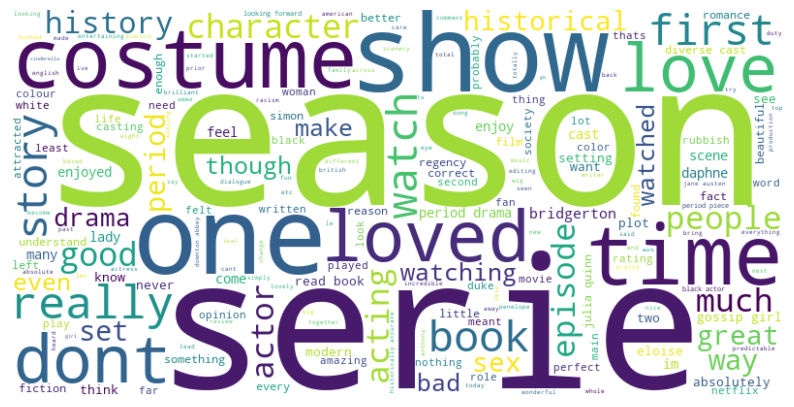

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the text data into a single string
all_text = ' '.join([text for text, label in data])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

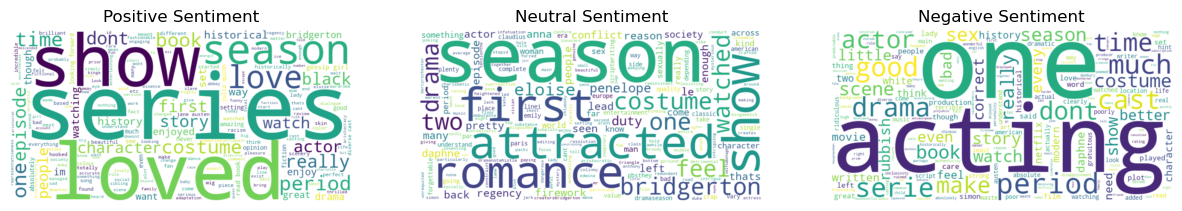

In [43]:
# Generate word cloud for positive sentiment
positive_text = ' '.join([text for text, label in data if label == 'Positive'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Generate word cloud for neutral sentiment
neutral_text = ' '.join([text for text, label in data if label == 'Neutral'])
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Generate word cloud for negative sentiment
negative_text = ' '.join([text for text, label in data if label == 'Negative'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display the word clouds
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.show()

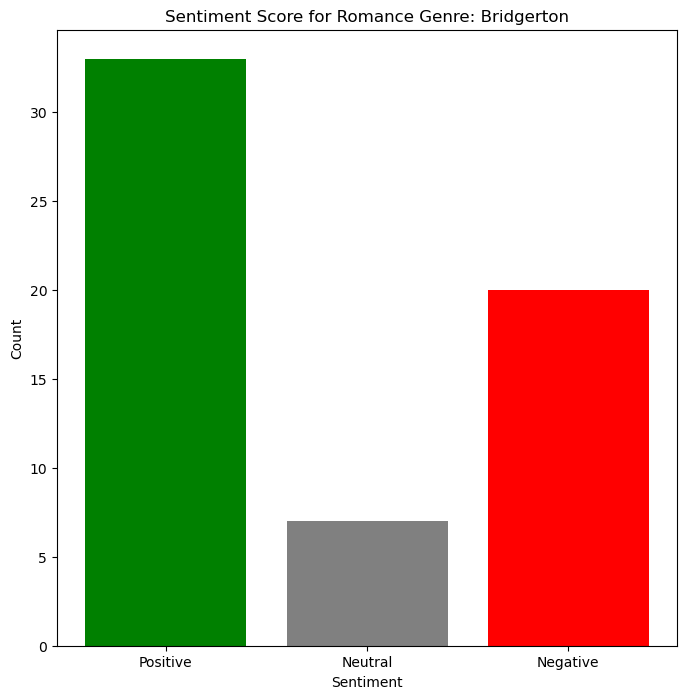

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Original data
data = [
    ("like took pride prejudice cinderella jane eyre little woman rolled together squeezed character developed drama top used modern music period correct musician added new level cringe heard itwhere good writer go", 'Negative'),
    ("wish people would look beyond colour factious period drama black people duke lady etc", 'Positive'),
    ("hooked first episode love diversity amongst actorscharacters mix downton abbey gossip girl work", 'Positive'),
    ("know actually somewhat entertaining watching lowiqers think theyre actor however quickly becomes tiresome wokness antieuropean fake history displayed lowiq series rewarded netflix cancelled subscription good luck netflix", 'Negative'),
    ("delightful escape bad story costume actor etc good comment race here bit history queen charlotte descended black portuguese royal line black also regency period black aristocrat albeit number exist nevertheless fictional account period history told today rule color skin matter come character show hamilton paved way certainly hope continues move away typecasting film", 'Positive'),
    ("duke duchess one white one tan deceiving family friend firstborn son named areal rubbish difficult tell one bothered real ridiculous charade attention read money rubbish well eight hour one life squanderedmiss austen would much amused m cast thousand come even close genius created small table twouptwodown modest housesnetflix try harder stop hiring poseur who talent pirate plagiarize betterseven weather phony", 'Negative'),
    ("billed modern classic fails hit mark every way two main foundation production script acting appallingly bad good form bad make least laughable set costume good look especially location acting bad actor ive seen better one infant school play decided vandalize every scene ruin location like watching total rubbish poorly written dreadfully acted dont waste time", 'Negative'),
    ("terrible dialog cliche galore lack even hint detail make poor period drama saccharine sweet chick flick low rate gossip girl script leave genre warrant little pedigree care required handle ala dumbing televisual art continues avoid", 'Negative'),
    ("really dont understand negative review series respect everyones opinion big fan historical show probably would never watched recommended friend pleasant surprise series enjoyed every second series nothing history fiction story simply set past lovely setting amazing wardrobe lovely cast smart engaging story line looking romantic series set alternative past simply based fiction enjoy serious history portrayed meaning strictly keep fact steer away show historical series personal level looking forward season", 'Positive'),
    ("absolute caricature th century regency britain clearly written produced american bbc much better ironically say american strong anglophile gratuitous sex season one luckily waned season two season two least interesting dramatic arc though still struggle find true dramatic benefit revealing lady whistledown end season dont understand actual british actor somehow sound like putting accent watched curiosity clearly word mouth interest", 'Negative'),
    ("historically accurate ok change history suit time absolutely dont get absolute ignorance comment color skin doesnt matter costume scenery beautiful dialogue funny story engaging thats", 'Positive'),
    ("yes gossip girl brazen show dame julie andrew amazing narrator depiction regency era london society season absolutely brilliant love element wendy darling jane austen much ado cinderella modern aspect gg molded brilliant fictional historical dramady actor writer director work together perfect trifecta effervescent bubble costume scenery diamond show", 'Positive'),
    ("costume great set perfectly lush really dont care writing acting pacing people screaming historical accuracy need get", 'Negative'),
    ("cant understand entertainment value american get bad scriptwriting show take place europe par emily paris complete crap forgettable", 'Neutral'),
    ("read book normally one love period drama family found one best period drama around loved casted", 'Positive'),
    ("fantastical soap opera period piece diverse cast utterly swoonworthy also appreciate new face none bring prior character theyre known story im keeping fingerscrossed there season come apparently book series total one bridgeton sibling aside main character really enjoyed eloise played claudia jessie", 'Positive'),
    ("one nice guilty pleasure released quite snobbish didnt watch glad changed mind really enjoyed let skip plot focus pleasure eye garden tea party oh outfit saucy sex scene mostly season though wonderful ton spoken english dont expect anything challenge brain historical accuracy go enjoy like would enjoy buttercream cake", 'Positive'),
    ("totally worth watching whole season rating show watching episode forbidden", 'Positive'),
    ("book sooooo much better dont understand need change story written book series would minded story added disappointment see series played written rating didnt shut found finding distraction wasnt nearly magical", 'Negative'),
    ("really dont want feel watch period drama cast eye blm movement apart poorly scripted acting wooden set good there really much else going", 'Negative'),
    ("bridgerton classic regency era costume dramaseason one firework romance side season two le firework single story linei watched plenty drama going way back claudius pbsthey vary quality depending creatorsbridgerton likeable middle road dramanot top bottom packi particular enjoy lady whistle poking fun aristocratic class", 'Neutral'),
    ("usually dont like adaptation book one though exeption loved first season set information character evwn first book specially loved georgemarinaphilip subplot", 'Positive'),
    ("opinion best series ever created representativeness series brought incredible im love looking forward second season", 'Positive'),
    ("perfect adaptation julia quinns book addition incredible diverse cast brings lot representativeness important nowadays really sad many people talking badly good series disgusting racism anyway watch bridgerton beautiful series wont regret", 'Positive'),
    ("costume setting music beautiful weve seen season lack substance intrigue led many bingewatch first gaping hole left resolution simon daphne romance love triangle anthony kate edwina feel forced none actor particularly charismatic heightened focus eloise detrimental actress eyerolls overreaction unrealistic conduct reminiscent anna chlumsky vivian inventing anna subplots redundant could crafted film left editing floor season werent enthralling first goround eg penelope unrequited infatuation colinmy rating average season season", 'Neutral'),
    ("gratuitous sex poor dialogue perfect décor style delightful color clean road house neat shiny people even farmer scientific fiction movie real period drama adopted book many sex absolutely necessary scene wedding chamber specially sacred place time one time hint enough", 'Negative'),
    ("talented brilliant incredible amazing showstopping spectacular never totally unique", 'Positive'),
    ("cant wait im ob know probably people read book give try wont hurt", 'Positive'),
    ("never read book seeing netflixs top indication series started watching first episode mean truly understand scarcity role black actor period piece honestly believe viewer would accept suggestion many member british aristocracy dark skin racism time exist however muttering joking time totally forgot started really enjoy series fact love seriesmuch seems historically accurate example woman slave social more time could strive make good match way could social standing turn would sibling etc wedlock pregnancy meant total ruination one entire familymy complaint would sex scene way overdone otherwise enjoyable historical series great way get one mind problemfilled present", 'Positive'),
    ("love love loved programme havent read book nothing except tv version judge found first couple episode hooked really cared character different trial tribulation particularly mystery behind lady whistledowns identity loved simon daphne story loved costume colour sheer escapism grim time dont get hater snob calling trash found delight start finish cant wait next season", 'Positive'),
    ("great series supposed book different version inspired like diverse cast amazing costume ive julia quinn fan since started writing think series bridgerton book proud", 'Positive'),
    ("creative concept period piecefamily drama mixed historically inaccurate feature representation ethnicity upperclass beautiful rendition modern song even though end season least thus far pretty predictable episode managed capture interest series culture definetely contributed certain revival fashion time", 'Positive'),
    ("downton abbey gossip girl baby would get bridgerton fan previous show one dazzle first setting set costume color scheme look great think cast great job really felt immersed show time period especially felt immersed bridgerton family first episode made big splash medefinitely curious see come next", 'Positive'),
    ("im thrilled show make criticism loved casting loved set costume loved kept essence spirit book loved episode felt long enough loved pen eloise love love lovethe thing would liked see lol wit julia quinn good ati want season want season", 'Positive'),
    ("first season pretty good broody mysterious duke giving nice mr darcyrochester vibe making romance innocent debutante feel dangerous intriguing reason jerk pretty lame least pose mystery creates genuine tensionthe second season awful main plot two lead misguided sens duty entire conflict insisting conform imaginary constraint people around tell thats stupid duty arent socially binding enough conflict hold together eight episode awhile annoying watch selfsabotage small potato surely society constraining enough back could come something little jazz", 'Neutral'),
    ("sorry could watch min queen behaves like drank sailor pub grace benevolence really editing first review seeing high score rating tried whatch one time picked episode impossible sophisticated taste movie degree art history movie nothing disappointment", 'Negative'),
    ("watched episode far maybe isnt fair judge seen whole season far im kind meh show really like character penelope eloise find lead kind boring drama show feel like something teen girl fanfici dont know worst show world could probably finish season fine time hasnt really captivated youre looking period piece show modern flair great helluva lot better", 'Neutral'),
    ("although love period drama english chinese literally could like main lead series plot also underwhelming say enjoy show enjoyed supporting cast much adored costume lovely voice acting julie andrew cast excellent job music wonderful said simply could bring like daphne simon prior part daphne sexploits husband guilttripping child absolutely mortified act alone rubbish spewed far much sex show without much substance daphne character grow simpleminded selfish wanting marry affluent husband love claim hah bear child simon better vengeful manchild make vow ultimately keep yet praised sold tv producer writer esteemed bachelorbachelorette though setting carried austenesque feel left wanting huge gap feel never fulfilled subsequent season eloises personality seemed liking beginning seemed like would redeem show actress came across rather annoying really put favourite lady danbury absolute thrill watch honestly reason anyone watch showin contrast another reviewer comment may asian one would think would support diverse cast though see past colour actor doubt great role would certainly way little irritating become big deal casting producer feel need hire people background personally would liked retaining white cast reason fact would historically accurate think ridiculous would look historical chinese drama white guy background inclusivity one thing inclusivity compromising authenticity anotherps read book book anything like show probably never touch know julia quinn wrote played huge role casting production series", 'Negative'),
    ("loved managed get essence character book screen loved scenery clothes well excitement everything presented loved much im looking forward nd season", 'Positive'),
    ("looking historical drama based true event fact youthis much fun watch character setting wardrobe colour movement storytelling imaginative assure fantasy fiction changed dayswe middle pandemic restriction bad news arriving everyday really want watch something linear sad heartbreakingwe want watch something jumpstart imagination make u giggle laugh blushhavent read book expect catching series thats way", 'Positive'),
    ("high hope love period film costume production piece stunning modern input material choice seamless beautiful strong sex scene ruined acting overworked watch period film authenticity reminder simpler time moral actually meant something", 'Negative'),
    ("hey dont fuss absolutely loved love jane austen beat compare show absolutely stunning way actress wow actor even wow pleasewatch", 'Positive'),
    ("im sure made england english would historically correct period time enjoyed story acting watched wonderful series downton abbey crown felt little let", 'Negative'),
    ("start id like say love period piece moviesshows skeptical since dont like gossip girl basic teen girl show bridgerton differentafter min hooked chemistry regejean page phoebe dynevor undeniable casting costume set editing acting phenomenal give try", 'Positive'),
    ("seems many people agree season le sexually intense first season watched conclude politically correct world today one attracted certain sex come across screen buying play attracted sex attracted woman know men attracted u reason came across actor attraction sexually yearn coupling googled found gay discerned thats sense maleness hetero man exudes homosexual man woman swept away someone acting season fall short", 'Neutral'),
    ("historicly correct instead enjoying movie serie escape everyday life crazuness come forced diversity thing dont make sense unwatchable cancel culture let cancel history rewrite make sick", 'Negative'),
    ("first couldnt care le diverse cast actor played simon lady danbury great personality anthony violet many others justwrong wasnt fan addition mr featherington boxing included one mentioned absurdity royalty plot needed ruined whole thing fleshing sibling nice also left lot blank spot daphne development", 'Negative'),
    ("every actoractress overacts every scene frankly frustrating perhaps frustrating right word perhaps right word rageinducing story predictable sun rising morning terrible acting add nauseating concoction left shelf netflix possible would given star", 'Negative'),
    ("binge watched show enjoyed watching binge watched agin next day jane austen gossip girl boy mixed one highly entertaining dress dance setting treat eye eagerly waiting season", 'Positive'),
    ("ive never heard word ton much life prior watching time id heard mean fashionable cryptic crossword rather fashionable societyhigh society aristocracy leading string another rare outdated expression refers baby rein cheesy dialogue doesnt stop one enjoyment though surfeit wig display wig become rare tax wig powder introduced racial situation though note hypocritical reaction would ensue play went back white people playing othelloi enjoyed watching see mysterious gossiping lady end silly pledge duke hastings made father unconvincing plot device even source amusement allegedly appears bookall shouldnt taken seriously rated highly entertaining enough merit", 'Positive'),
    ("season one season two theme history regency period costume drama romance anonymous gossip british society feminism fake dating enemiestolovers courtship marriage reputation duty familytop three character penelope featherington eloise bridgerton daphne bridgerton", 'Neutral'),
    ("must watch history fiction meet pure entertainment loved idea coming life many people different looking forward session", 'Positive'),
    ("fact drama need lot adult scene boost view said shallow story plot nothing like supposed timeline storythere said", 'Negative'),
    ("series opinion strength weakness like great costume perfect soundtrack scenario win anyone actor choice would change point view even series time see reason choose black actor role royalty since stereotype black actor play slave butler help fight racism today opinion", 'Positive'),
    ("story tv show dont think song wrecking ball miley cyrus time song orchestra performed last ball kate lord anthony dance", 'Positive'),
    ("jeez peoplewhats bad review read romance novel would know based collection book julia quinn meant racy meant fun definitely kid quit complaining watch eight episode enjoy", 'Positive'),
    ("pedestrian predictable pandering ploddinggood costume good setsjust film actual austen novel againfor brouhahajust basic take trope", 'Negative'),
    ("even good historical approach full bad acting insane political correct b weird use black actor king character please waste second show", 'Negative'),
    ("thoroughly entertained thrilled show revolutionary vision", 'Positive'),
    ("loved everything serious funny delicious everything could want", 'Positive')   
]

# Extract labels from data
labels = [label for _, label in data]

# Count occurrences of each label
label_counts = Counter(labels)

# Define the order of sentiments
ordered_labels = ['Positive', 'Neutral', 'Negative']

# Plotting the bar chart
plt.figure(figsize=(8, 8))
plt.bar(ordered_labels, [label_counts[label] for label in ordered_labels], color=['green', 'grey', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Score for Romance Genre: Bridgerton')
plt.show()

# Discussions 

#### Performance Comparison:
1. Lexicon-based Approach (VADER):

- Accuracy indicates the overall correctness of the model, which is 60%.
- VADER has higher precision for positive (0.61) and negative (0.60) compared to neutral (0.00). 
- It also shows high recall for positive (0.91) compared to neutral (0.00) and negative (0.30) which shows very low. 
- F1-score for positive is relatively high (0.73) but it’s low for negative (0.40) and neutral (0.00).

2. Lexicon-based Approach (TextBlob):

- Accuracy is slightly higher than VADER at 62%.
- TextBlob has higher precision for positive (0.64) and negative (0.62) compared to neutral (0.00)
- Recall is higher for positive (0.88) but low for neutral (0.00) and negative (0.40).
- F1-score shows relatively good for positive (0.74) and negative (0.48) but not for neutral (0.00).

##### Limitation: 
Lexicon-based (VADER and TextBlob)

- Both lexicon-based models struggles with neutral sentiment and resulting in zero scores for precision, recall and F1-score.
- TextBlob has slightly better performance overall compared to VADER in terms of accuracy 62% and F1-score for negative sentiment.


3. Machine learning-based approach (Naïve Bayes):

- Accuracy is 58%, which is lower than both VADER and TextBlob.
- Precision is very high for negative (0.93) compared to positive (0.56) and neutral (0.00).
- Recall is perfect for positive (1.00) but very low for negative (0.12) and neutral (0.00).
- F1-score is decent positive (0.72) compared to negative (0.12) and neutral (0.00).


4. Machine learning-based approach (SVM):

- Accuracy is the highest at 73%.
- Precision is high for positive (0.81) and negative (0.69) then moderate for neutral (0.36).
- Recall is high for positive (0.87) and negative (0.76), and low for neutral (0.21).
- F1-score is the highest among all models for positive (0.84) and negative (0.72), indicating a balanced performance. 

##### Limitation:  
Machine learning-based (Naives Bayes and SVM)

- SVM outperforms Naives Bayes in every metric including precision, recall, F1-score and accuracy. 
- Naïve Bayes performs poorly in negative sentiment recall, leading to low overall F1-score and accuracy.

##### Summary:
Overall, machine learning-based approaches perform better compared to lexicon-based approaches, which are VADER and TextBlob in this specific dataset. In addition, SVM shows the highest accuracy 73% among all classifiers and balanced performance across all metrics making it the most reliable model for romance movie review sentiment analysis, while Naïve Bayes performs slightly lower but still reasonably well. 

##### Data Visualization:
- Positive sentiment: The majority of reviews for romance genre “Bridgerton” are positive as indicated by the tallest bar in green.
- Neutral sentiment: There are very few neutral reviews as indicated by the shortest bar in gray.
- Negative sentiment: There is a significant number of negative reviews but it is less than the positive reviews as indicated by the red bar. 

From the bar chart, we can conclude that romance genre “Bridgerton” generally receives more positive feedback compared to neutral and negative feedback. This suggests that viewers are more likely to express positive sentiments about the movie with relatively fewer negative sentiments and minimal neutral sentiments.